#### Notebook's structure:
 
 ##### Gather and assess data: 
 1. Startup (for running need here local paths)
 2. Data loading, target and id variables
 3. Two possible target variables: Job Satisfaction and Income
 
 ##### Cleaning and visualisations:
 4. Replacements and filtering
 5. Handling missing data
 6. Exploratory Analysis
 
 ##### Model
 7. Handling multicolinearity and dimensionality reduction
 8. Linear Model


# 1. Startup

In [6]:
# path to folder {...}notebooks/
project_dir = "/Volumes/Workspace/Workspace-Projekte/UdacityDSZ/Projekt1/schneeflocken/notebooks"
data_dir = project_dir + "/data"

import sys
sys.path.append(project_dir)


As subject for this analysis data was downloaded from: https://insights.stackoverflow.com/survey
* Because 2019 and 2020 have similar data structures, only data from these 2 years was combined.
* Going to far back wouldn't be usefull, especiall in a rapidly changing Data Science (DS) working industry.

<b>List of assumptions:</b>
	1. Countries have similar culture and economic level
	2. Users have similar expectations in life
	3. All groups are represented, no bias toward those that are actively on StackOverflow
	4. Salaries where given in same form, gross figures
	5. User submitted true information about themselves (such as salary)
	6. Job Satisfaction was reported by users without influence of recent events (eg just a one bad day, doesn’t make a 5 to 4)
	7. Users earn the proper amount of money, that is the fair income for their proficiency on their local markets

One can already see the pattern here, most of them probably are not true; difficult or impossible to actually asses.

<b><i>Since between countries cultural and economic differences exist, a reduced set was selected; initially US was considered in, partly because of data dimension, but the further exploratory analysis (EA) did not support keeping it, since the levels of income are much higher that the rest of european countries. 
Thus the final list includes almost entirely european countries: "United Kingdom", "Ireland", "Canada", "Germany", "Austria", "Netherlands", "Sweeden", "Finland", "France", "Belgium"</b></i>

The interest here lies around following questions:
 - <p style="color:red">Consider looking for a new DS job, what should be the fair price to ask?</p> Flipside this question and it becomes a cost consideration for a company: how much should a company calculate for costs on a new data scientist?
<i>A <b>linear model</b> for income was derived that explains about 22% of the variance in data; for practical reasons an Excel was prepared where 5 models were brought together in a voting system, since they concentrate on various aspects (5 models: basics, self agency, company type, motivation to leave, education)
</i>

 
 - <p style="color:red">Do you need strong programming skills to perform well (in terms of income and satisfaction)?</p>
<i> The combination between age and years of professional coding experience seem to be a constant on all models. This is not surprising, since this aspect is central to being able to do data science at a deeper level, if necessary.
Models picked consistently feature YearsCodePro for an average of <b>+825 dollars</b> per year of professional coding experience.
</i> 
        
 
 - <p style="color:red">How does strong knowledge of maths and statistics play a role in a successful DS (both good salary and job satisfaction)?</p>
<i> It seems for those that are at satisfaction levels of 4 and 5 relatively earn about the same <b>65k to 70k</b>
These have either a <b>Computer Science degree, Mathematics, Statistics or Engineering</b>. Specializations in <b>business related disciplines</b> such as accountants, controlling and marketing are also earning better than other groups. This relation does not seem to hold consistently from country to country; for example in Germany a CS degree brings less than Mathematics but in Austria the relationship changes the sign. This could be related to local market situation, cultural differences or simply variance in the data, which makes assessing all countries difficult, even with the current selection. </i>


 - <p style="color:red">Which programming languages are often involved?</p>
<i> There is no suprise that <b>SQL (67%), Python (59%)</b>, Bash/Shell/PowerShell (50%) get often chosen as features, but the interesting thing in the result was that Python ofen gets negative weights. This could be explained with the hypothesis that knowing new languages (or some other language that is not popular) leads to a positive change in income. This hypothesis is supported by features like LanguageWorkedWith_Kotlin which got positive weights in several models</i> 


 - <p style="color:red">What makes a data scientist look for a new job?</p>
<i>
It seems between those that are not looking and those that might be interested (not looking actively) there isn’t a strong difference in earnings. This changes in case of those that are actively seeking, they tend to have <b>lower current average wages</b>. <br>
This result is in accordance with the frequency table of the <b>NEWJobHunt</b> variable which shows that <b>„Better compensation“ represents 58% of all cases, while in 21.8% cases some conflict is involved </b> with either direct managers, company culture or even team members. <br>
Not suprisingly job satisfaction correlates strongly with feature <b>JobSeek</b>: that is for lower values than or eual to 3, user are actively seeking, while at 4 they're could be interested. The only situation where no job is searched is at job satisfaction level 5.<br>
These observations might be explained by:
- Relative income on local market is more important than the absolute value
- Since larger income correlates with large corporations it might be that in these situations stress conditions are higher. This cannot be exhaustively checked with the current data.    
</i>


In [7]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbn

from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats
from importlib import reload
from contextlib import contextmanager

@contextmanager
def SuppressPandasWarning():
    with pd.option_context("mode.chained_assignment", None):
        yield

# further my own standard methods placed in their own scripting files for use in other projects
from eda import dersatz, dabfrage, dbeschreiben
reload(dbeschreiben)
reload(dabfrage)

pass

##### Methods specific to this notebook

In [8]:
was_ist_das = lambda schema, xkey: schema[schema.Column == xkey].Question.values.tolist()

"""
replace embedded lists string elements when sep is given:
    xs = "blah;blup;bleep"
    sep = ";"
    repl_strlist(xs, 'blup', 'blap')
    => 'blah;blap;bleep'
"""
stringlist = lambda xs, sep: list(map(lambda x: x.strip(), str(xs).split(sep)))
repl_strlist = lambda xstr_sep, xval, xval_new, sep:\
                        sep.join(
                            list(map(lambda x: x if x != xval else xval_new, stringlist(xstr_sep, sep)))
                        )

    
def get_dataframe_filled(xdfInput, num_cols, id_col, target_col):
    """ Performs replacement of missing values by using KNN generate clusters to find group averages
    """
    dfres, _ = dersatz.ersatz_mit_knn(xdfInput, xcol=num_cols[0], ignoriere_spalten=[id_col, target_col],
                                      thresholdNullWerteCluster=0.7, nclust=15)
    for xc in filter(lambda x: x not in [id_col, target_col, num_cols[0]], xdfInput.describe().columns):
        dfres, _ = dersatz.ersatz_mit_knn(dfres, xcol=xc, ignoriere_spalten=[id_col, target_col],
                                          thresholdNullWerteCluster=0.7, nclust=15)
    return dfres


def setval(dfin, xcol, xval, xval_new):
    """ For categorical features where mostly values one can replace those few strings to correponding value at 
    end of the interval: eg "Less than 5 years" => "4"
    Later all values can be used as numbers
    It only becomes a problem, when lots of data would be at the margins of the interval, which is not the case here
    """
    for ik in range(dfin.shape[0]):
        xw = str(dfin.at[ik, xcol])
        if xw == xval:
            dfin.at[ik, xcol] = xval_new
    return dfin
            
def repl_df_dict(df, xcol, dict_repl, repl_strings=True, sep=";"):
    """ Given a replacement dictionary for a categorical variable, replaces strings with given values
    Usefull if the variable can be ordered in logical manner (good, neutral, bad)
    df: data frame
    dict_repl: replacement dictionary
    repl_strings: whether the replacements values are numbers or strings
    """
    dfvalues = df[xcol].values.tolist()        
    for xkey in dict_repl.keys():
        if repl_strings:
            dfvalues = [repl_strlist(t, xkey, dict_repl[xkey], sep) for t in dfvalues]
        else:
            dfvalues = [t if xkey != t else dict_repl[xkey] for t in dfvalues]    
    return dfvalues

def filter_by_devtype(df):
    # Select by DevType -> data scientists, data engineers, scientists
    df = df[list(map(lambda x: 'data' in str(x).lower() or 'scientist' in str(x).lower(), df['DevType'].values.tolist()))]
    df = df[list(filter(lambda x: x!='DevType', df.columns))]
    print("Dimensionality:", df.shape)    
    return df


# 2. Data loading, target and id variables

#### Set <i>income (ConvertedComp) </i> as target variable and <i>Respondent</i> as ID

In [9]:
# Filter columns of interest
startup_cols = ["Respondent", "ConvertedComp", "JobSat",
               "MainBranch", "Hobbyist", "Age", "Age1stCode", "Country",
               "EdLevel", "Employment", "JobSeek", "JobFactors",
               "LanguageWorkedWith",
               "NEWJobHunt", "NEWLearn",
               "OpSys", "OrgSize", 
               "PurchaseWhat", 
               "UndergradMajor",
               "WorkWeekHrs", "YearsCode", "YearsCodePro"
               ]

# Load Data (2020)
df2020 = pd.read_csv('{}/2020/survey_results_public.csv'.format(data_dir))
schema2020 = pd.read_csv('{}/2020/survey_results_schema.csv'.format(data_dir))

# Load data (2019) and match columns
df2019 = pd.read_csv('{}/2019/survey_results_public.csv'.format(data_dir))
schema2019 = pd.read_csv('{}/2019/survey_results_schema.csv'.format(data_dir))
for xc in ["NEWJobHunt", "NEWLearn", "NEWOnboardGood"]:
    df2019[xc] = [None] * df2019.shape[0]

# because of the filter on DevType (looking for Data Scientist Jobs), the dimensionality gets strongly reduced
df2020 = filter_by_devtype(df2020)
df2019 = filter_by_devtype(df2019)
df = pd.concat([df2020[startup_cols], df2019[startup_cols]])
df.head()


Dimensionality: (13098, 60)
Dimensionality: (21290, 87)


,Respondent,ConvertedComp,JobSat,MainBranch,Hobbyist,Age,Age1stCode,Country,EdLevel,Employment,...,LanguageWorkedWith,NEWJobHunt,NEWLearn,OpSys,OrgSize,PurchaseWhat,UndergradMajor,WorkWeekHrs,YearsCode,YearsCodePro
9,10,32315.0,Very satisfied,I am a developer by profession,Yes,22.0,14,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed full-time,...,HTML/CSS;Java;JavaScript;Python;SQL,Curious about other opportunities;Better compe...,Every few months,Windows,2 to 9 employees,I have a great deal of influence,Mathematics or statistics,36.0,8,4
15,16,108576.0,Very satisfied,I am a developer by profession,Yes,45.0,8,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",...,Bash/Shell/PowerShell;HTML/CSS;Java;JavaScript...,Having a bad day (or week or month) at work;Cu...,Once a year,MacOS,"Just me - I am a freelancer, sole proprietor, ...",NaN,"Computer science, computer engineering, or sof...",50.0,37,23
21,22,NaN,Slightly dissatisfied,I am a developer by profession,Yes,NaN,18,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,...,Java;Python,Better compensation;Better work/life balance;W...,Every few months,Windows,500 to 999 employees,NaN,"Computer science, computer engineering, or sof...",50.0,10,2
24,25,NaN,Neither satisfied nor dissatisfied,I am a developer by profession,No,NaN,25,Portugal,"Associate degree (A.A., A.S., etc.)",Employed full-time,...,Bash/Shell/PowerShell;C,Curious about other opportunities;Growth or le...,Once every few years,Windows,100 to 499 employees,I have little or no influence,"Computer science, computer engineering, or sof...",40.0,23,18
26,27,NaN,NaN,"I used to be a developer by profession, but no...",Yes,NaN,12,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,...,Bash/Shell/PowerShell;C;C++;Java;Python;SQL,NaN,Once every few years,Linux-based,NaN,NaN,"A humanities discipline (such as literature, h...",NaN,20,20


In [10]:
df.sample(10).iloc[5]

Respondent                                                        10424
ConvertedComp                                                      4272
JobSat                                               Slightly satisfied
MainBranch                               I am a developer by profession
Hobbyist                                                            Yes
Age                                                                  25
Age1stCode                                                           18
Country                                                            Iran
EdLevel                     Master’s degree (MA, MS, M.Eng., MBA, etc.)
Employment                                           Employed full-time
JobSeek               I’m not actively looking, but I am open to new...
JobFactors            Financial performance or funding status of the...
LanguageWorkedWith                           HTML/CSS;JavaScript;Python
NEWJobHunt                                                      

In [11]:
df.shape

(34388, 22)

In [12]:
dbeschreiben.frequenz_werte(df, xcol="JobSat", prozente=True, sep=";")

,id
JobSat,
Very satisfied,0.290741
Slightly satisfied,0.282453
Slightly dissatisfied,0.130162
nan,0.128650
Neither satisfied nor dissatisfied,0.105386
Very dissatisfied,0.062609


In [13]:
# Variables: simply changing here the target variable will lead to the specific model
id_col     = "Respondent"
target_col = "ConvertedComp" # "JobSat" # "ConvertedComp"

# two targets of interest: JobSat and ConvertedComp
dict_satisfaction = {
    "Very satisfied": 5,
    "Slightly satisfied": 4,
    "Neither satisfied nor dissatisfied": 3,
    "Slightly dissatisfied": 2,
    "Very dissatisfied": 1
}
dfvalues = repl_df_dict(df, "JobSat", dict_satisfaction, repl_strings=False)
df['JobSat'] = dfvalues


In [14]:
df[["ConvertedComp", "WorkWeekHrs"]].sample(5)

,ConvertedComp,WorkWeekHrs
71300,71000.0,40.0
47617,92000.0,50.0
27395,NaN,NaN
13818,14300.0,50.0
71708,135000.0,45.0


# 3. Two possible target variables: Job Satisfaction and Income

In [15]:
# define successfull DS as someone who has a high paycheck and is satisfied with the job
q1 = df['ConvertedComp'].quantile(0.25)
q2 = df['ConvertedComp'].quantile(0.5)
q3 = df['ConvertedComp'].quantile(0.85)

xquantiles_income = [q1, q2, q3]
print("Quantiles for ConvertedComp:", xquantiles_income)
xfgetplace = lambda x: np.sum(list(map(lambda q: x > q, xquantiles_income))) + 1

df['ConvertedCompPos'] = [xfgetplace(t) if not np.isnan(t) else np.nan for t in df['ConvertedComp'].values]

df[["ConvertedComp", "ConvertedCompPos", "JobSat"]].sample(5)

Quantiles for ConvertedComp: [25296.0, 56264.0, 135000.0]


,ConvertedComp,ConvertedCompPos,JobSat
78312,78332.0,3.0,4.0
5774,NaN,NaN,NaN
70058,18000.0,1.0,4.0
4675,128324.0,3.0,4.0
28075,8760.0,1.0,4.0


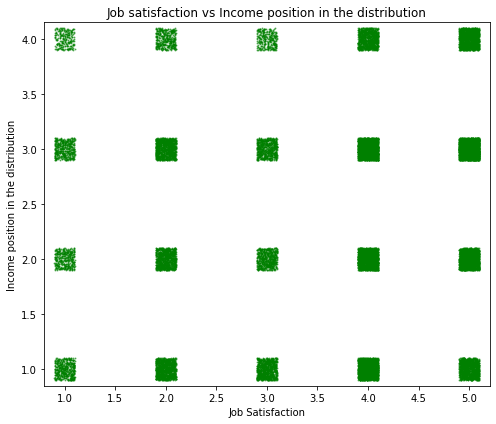

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
df.plot.scatter(x='JobSat', y='ConvertedCompPos', 
                s=1, alpha=.5, color='green', ax=ax)
dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.1, 0.1, offsets.shape)
dots.set_offsets(jittered_offsets)
ax.set_title('Job satisfaction vs Income position in the distribution')
ax.set_ylabel('Income position in the distribution')
ax.set_xlabel('Job Satisfaction')
plt.tight_layout()
plt.show()

,id
SuccessfullAsDS,
0.0,0.757357
1.0,0.242643


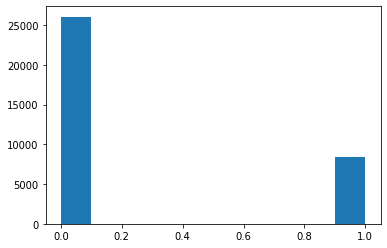

In [17]:
# call successfull data scientists, those that have high paychecks as well as job satisfaction
df['SuccessfullAsDS'] = [1.0 if (jobsat >= 4 and incomePos >= 3) else 0.0 for jobsat, incomePos in 
                                    df[["JobSat", "ConvertedCompPos"]].values]

_ = df['SuccessfullAsDS'].hist(grid=False)
dbeschreiben.frequenz_werte(df, xcol="SuccessfullAsDS", prozente=True, sep=";")


It doesn't seem for job satisfaction to strictly go with the income. If we would call those users that earn above average while being satisfied (4 or 5) then only 25% of them can be classified as such.

In [18]:
# drop ConvertedCompPos, SuccessfullAsDS, JobSat
df = df[list(filter(lambda x: x != "ConvertedCompPos", df.columns))]
df = df[list(filter(lambda x: x != "SuccessfullAsDS", df.columns))]

# 4. Replacements and filtering

### Filter and replace data upfront based on EA-Results

In [19]:
# this was an ongoing process getting back and forth.
xr = dbeschreiben.frequenz_werte(df, xcol="Country", prozente=False, sep=";")
xr['Country'] = xr.index
xr = xr[['Country', 'id']]; xr.columns = ['Country', 'count']
xr = xr.reset_index(drop=True)
xr[xr['count'] > 100].head(5)

,Country,count
0,United States,8394
1,India,2989
2,Germany,2361
3,United Kingdom,2032
4,Canada,1216


Choosing just those countries that culturally best fit together in terms of revenues, style, etc. so as to make the analysis easier to interpret.

There's a problem with US. The income is so high compared to other countries, that a model for all doesn't perform well (about 3 to 5 percent loss in variance explained R^2).

In [20]:
# Countries "United States", "Switzerland", "Denmark", "Norway"
selected_countries = ["United Kingdom", "Ireland", "Canada",
                      "Germany", "Austria", "Netherlands", "Sweeden", "Finland",
                      "France", "Belgium"]
df = df[list(map(lambda x: x in selected_countries, df['Country'].values))]

# Not using records that are missing target column value
df = df[list(map(lambda x: not np.isnan(x) and x is not None and not np.isinf(x), 
                 df[target_col].values))]

# keep only records of users aged min 20 years
df = df[list(map(lambda x: x >= 20, df["Age"].values))]

df = df.reset_index(drop=True)
print(df.shape)

(5536, 22)


In [21]:
# Replacements

# Age1stCode
df = setval(df, xcol="Age1stCode", xval="Younger than 5 years", xval_new="4")
df = setval(df, xcol="Age1stCode", xval="Older than 85", xval_new="86")
df["Age1stCode"] = df["Age1stCode"].astype(np.float)

# YearsCode, YearsCodePro
for xcol in ["YearsCode", "YearsCodePro"]:
    df = setval(df, xcol=xcol, xval="Less than 1 year", xval_new="0")
    df = setval(df, xcol=xcol, xval="More than 50 years", xval_new="51")
    df[xcol] = df[xcol].astype(np.float)


In [22]:
# Replacements with dictionaries

_dict = {
    'I am a developer by profession': 'DEV', 
    'I am not primarily a developer, but I write code sometimes as part of my work': 'DS', 
    'I used to be a developer by profession, but no longer am':'OTHER', 
    'I am a student who is learning to code':'OTHER', 
    'I code primarily as a hobby':'OTHER'
}
dfvalues = repl_df_dict(df, "MainBranch", _dict)
df['MainBranch'] = dfvalues


_dict = {
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor', 
    'Bachelor’s degree (BA, BS, B.Eng., etc.)': 'Bachelor',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master',    
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)': 'Master',    
    'Other doctoral degree (Ph.D., Ed.D., etc.)': 'Doctoral',
    'Other doctoral degree (Ph.D, Ed.D., etc.)': 'Doctoral',
}
for xkey in ['Some college/university study without earning a degree', 
             'Associate degree', 'Associate degree (A.A., A.S., etc.)'
             'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
             'nan', 'Professional degree (JD, MD, etc.)', 'I never completed any formal education', 
             'Primary/elementary school',
             'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 
             'Associate degree (A.A., A.S., etc.)']:
    _dict[xkey] = 'other'
dfvalues = repl_df_dict(df, "EdLevel", _dict)
df['EdLevel'] = dfvalues

_dict = {
    'Employed full-time': 'fulltime', 
    'Independent contractor, freelancer, or self-employed': 'one man show', 
    'Employed part-time': 'parttime', 
    'Not employed, but looking for work': 'other'
}
dfvalues = repl_df_dict(df, "Employment", _dict)
df['Employment'] = dfvalues


_dict = {
    'I’m not actively looking, but I am open to new opportunities':'somewhat', 
    'I am not interested in new job opportunities':'no', 
    'I am actively looking for a job':'yes', 
    'nan':'ItsASecret'
}
dfvalues = repl_df_dict(df, "JobSeek", _dict)
df['JobSeek'] = dfvalues


_dict = {
    'Flex time or a flexible schedule': 'flexibility', 
    'Opportunities for professional development': 'career', 
    "Languages, frameworks, and other technologies I'd be working with": 'tech savvy', 
    'Languages, frameworks, and other technologies I’d be working with': 'tech savvy',     
    'Remote work options': 'remote work', 
    "Industry that I'd be working in": 'domain', 
    'Industry that I’d be working in': 'domain',     
    "Specific department or team I'd be working on": 'work environment', 
    'Diversity of the company or organization': 'work environment', 
    'Specific department or team I’d be working on': 'work environment',     
    'Office environment or company culture': 'work environment',     
    'Financial performance or funding status of the company or organization': 'financial stability', 
    'Family friendliness': 'free launch', 
    'How widely used or impactful my work output would be': 'idealist',     
    'nan': 'ItsASecret'    
}
dfvalues = repl_df_dict(df, "JobFactors", _dict, repl_strings=True)
df['JobFactors'] = dfvalues


_dict = {
    'Better compensation': 'cash', 
    'Curious about other opportunities': 'cash', 
    'Growth or leadership opportunities': 'chef', 
    'Wanting to work with new technologies': 'nomad', 
    'Better work/life balance': 'stressedout', 
    'Trouble with leadership at my company': 'stressedout', 
    'Looking to relocate': 'situational', 
    'Trouble with my direct manager': 'stressedout', 
    'Trouble with my teammates': 'stressedout',     
    'Just because': 'other', 
    'Having a bad day (or week or month) at work': 'other', 
    'nan': 'other', 'None': 'other',
    'Wanting to share accomplishments with a wider network': 'other'
}
dfvalues = repl_df_dict(df, "NEWJobHunt", _dict, repl_strings=True)
df['NEWJobHunt'] = dfvalues


_dict = {
    'Every few months': 'month', 
    'Once a year': 'year', 
    'Once every few years': 'decade', 
    'Once a decade': 'never',
    'nan': 'other', 'None': 'other'
}
dfvalues = repl_df_dict(df, "NEWLearn", _dict, repl_strings=True)
df['NEWLearn'] = dfvalues


_dict={
    'Windows': 'Win', 
    'Linux-based': 'Unix', 
    'MacOS': 'Mac', 
    'nan': 'ItsASecret', 
    'BSD': 'Unix'
}
dfvalues = repl_df_dict(df, "OpSys", _dict)
df['OpSys'] = dfvalues


_dict = {
    '2-9 employees': 'empl_2_19',
    '20 to 99 employees': 'empl_20_500', 
    '100 to 499 employees':'empl_20_500', 
    '10,000 or more employees': 'empl_10kp',     
    '2 to 9 employees':'empl_2_19', 
    '10 to 19 employees': 'empl_2_19', 
    '500 to 999 employees':'empl_500_10k', 
    '1,000 to 4,999 employees':'empl_500_10k', 
    '5,000 to 9,999 employees':'empl_500_10k',
    'nan': 'ItsASecret', 
    'Just me - I am a freelancer, sole proprietor, etc.': 'OneManShow',
}
dfvalues = repl_df_dict(df, "OrgSize", _dict)
df['OrgSize'] = dfvalues


_dict = {
    'I have some influence': 'some influence', 
    'I have little or no influence': 'no influence', 
    'nan': 'ItsASecret', 
    'I have a great deal of influence': 'strong influence'
}
dfvalues = repl_df_dict(df, "PurchaseWhat", _dict)
df['PurchaseWhat'] = dfvalues


_dict = {
    'Computer science, computer engineering, or software engineering': 'CS', 
    'Mathematics or statistics':'PureMaths', 
    'Another engineering discipline (such as civil, electrical, mechanical, etc.)':'Engineering',
    'Another engineering discipline (ex. civil, electrical, mechanical)': 'Engineering',
    'Information systems, information technology, or system administration': 'IT',     
    'A business discipline (such as accounting, finance, marketing, etc.)': 'SGA',     
    'nan': 'ItsASecret', 
}
for xkey in ['A natural science (ex. biology, chemistry, physics)', 
             'A business discipline (ex. accounting, finance, marketing)', 
             'A humanities discipline (ex. literature, history, philosophy)', 
             'A humanities discipline (such as literature, history, philosophy, etc.)',
             'A social science (ex. anthropology, psychology, political science)', 
             'A social science (such as anthropology, psychology, political science, etc.)',
             'Fine arts or performing arts (ex. graphic design, music, studio art)',
             'Fine arts or performing arts (such as graphic design, music, studio art, etc.)',
             'A health science (ex. nursing, pharmacy, radiology)',
             'Web development or web design',
             'A health science (such as nursing, pharmacy, radiology, etc.)',
             'A natural science (such as biology, chemistry, physics, etc.)',
             'I never declared a major'
            ]:
    _dict[xkey] = 'Other'
dfvalues = repl_df_dict(df, "UndergradMajor", _dict)
df['UndergradMajor'] = dfvalues


_dict = {}
for xkey in ['SQL', 'Python', 'Bash/Shell/PowerShell',
            'C++', 'C', 'R', 'Ruby', 'Rust', 'Kotlin', 'Swift']:
    _dict[xkey] = xkey
for xkey in ['JavaScript', 'HTML/CSS', 'Java', 'C#', 'PHP', 'TypeScript', 'VBA', 
             'Go', 'Other(s):', 'Assembly',  'Objective-C', 'Scala',
             'Perl', 'Dart', 'F#', 'nan', 'Clojure', 'Elixir', 'Erlang', 'WebAssembly']:
    _dict[xkey] = 'other'
dfvalues = repl_df_dict(df, "LanguageWorkedWith", _dict)
df['LanguageWorkedWith'] = dfvalues




In [23]:
# used to fill up the dictionaries and check the result of the mapping for various categorical variables
cat_cols = list(filter(lambda x: x not in num_cols and x not in [id_col, target_col], df.columns))
for xcol in cat_cols:
    print("\n==========================")
    print("COL: {}".format(xcol))
    xr = dbeschreiben.frequenz_werte(df, xcol=xcol, prozente=False, sep=";")
    print(xr.index.values.tolist())

NameError: name 'num_cols' is not defined

Further filters:

In [ ]:
# Age over 65 ist very unprobable
for ik in range(df.shape[0]):
    if df.at[ik, 'Age'] >= 65:
        df.at[ik, 'Age'] = np.nan


# if Age < YearsCode or Age1stCode > Age something is wrong with at least one of them
for ik in df[list(map(lambda x: x[0] < x[1], df[["Age", "YearsCode"]].values))].index:
    if df.at[ik, 'Age'] >= df.at[ik, 'YearsCode']:
        df.at[ik, 'YearsCode'] = np.nan
    if df.at[ik, 'Age1stCode'] >= df.at[ik, 'Age']:
        df.at[ik, 'Age1stCode'] = np.nan


# ConvertedComp too large?
for ik in df.index:
    if df.at[ik, 'ConvertedComp'] >= 200000: # even if someone would indeed earn that much, no point in keeping
        df.at[ik, 'ConvertedComp'] = np.nan
    if df.at[ik, 'ConvertedComp'] == 0.0:
        df.at[ik, 'ConvertedComp'] = np.nan        

if target_col == "ConvertedComp":
    df = df[list(map(lambda x: not np.isnan(x), df[target_col].values))]
    df = df.reset_index(drop=True)


for ik in df.index:
    if df.at[ik, 'WorkWeekHrs'] >= 75:
        df.at[ik, 'WorkWeekHrs'] = np.nan



In [ ]:
# separate categorical and numerical features
num_cols = list(filter(lambda x: x not in [id_col, target_col], df.describe().columns))
cat_cols = list(filter(lambda x: x not in num_cols and x not in [id_col, target_col], df.columns))

print(num_cols, "\n")
print(cat_cols, "\n")
print(target_col)

# 5. Handling missing data

#### Fill up missing values for numeric variables using an iterative clustering method
This is not definitive, since I'm getting back and forth through EA-Phase

In [ ]:
dbeschreiben.xProzentNullenInDF(df[num_cols + [target_col]])

In [ ]:
# perform a replacement of mising values by using k-means clustering
# the idea is to iterate over each feature, that has missing values, 
#     cluster data and replace those missing values with the centers of clusters
dfres = get_dataframe_filled(df, num_cols, id_col, target_col)
dfres['JobSat'] = [int(np.round(t, 0)) for t in dfres['JobSat']]

# 6. Exploratory Analysis

Numeric and categorical values treated in separate dataframes

In [ ]:
dfnum = dfres[num_cols + [target_col]]
dfcat = dfres[cat_cols]

In [ ]:
# export for Rapidminer visualisations
N = min(dfres.shape[0], 10000)
xselekt_cols = ["JobSat", "Age", "YearsCodePro", "ConvertedComp", "WorkWeekHrs", "EdLevel"]
dfres[xselekt_cols].sample(N).to_csv(data_dir + "/2rm_ea.csv", encoding="utf-8", index=False)

dfres.describe()

### Visualisations with Rapidminer

<b> All Referenced diagrams are in /data/diagrams/ folder </b>

RM visualizations to help keeping some of the variables that might help explaining either income or job satisfaction

    - ConvertedComp: 
    After cleaning up values larger than 0.5 Mil the average value lies at about 96k (including US data) and about 65k without considering US. This is the reason why US data was not included in the final analysis.

<b>VIS1</b>: Interesting how the high Salary describes almost a U-shape curve with satisfaction. This could be seen as the of the mean: the least and the highest satisfaction levels correspond to highest income.

    - Age: does not seem to be trustworthy from 65 upwards judging by the histogram.
    Some values are questionable, for example: 
        - 177 users report being 65 years old or older out of which 91 saying they’re professional developers, while it may be that this number of people are legitimate older developers, taking them into acount for our purpose of analysing data scientists especially is not recommended, as to reduce the possible influence of outliers
        - One record reports a value for age of 279.

One way to go about this is to set these values to None and redo the step for filling of missing values. Considering Age1stCode looks like most are now about 30 years old and started their Coding life in early life, 10 - 16 years.

Further interesting features are Age1stCode, YearsCode and YearsCodePro.
    - There are some records where YearsCode > Age, which can’t be true, so can be set as None
    - Also there is important that Age1stCode > Age holds

In all cases they can be set to None and passed to the method that will try to replace all missing values
After filtering and taking care of possible wrong values, the Histograms leads to following conclusions out the visual inspection:
    - On average users age lie around value 30. Most of the survey users started at an early age of less than 16, more than 10
    - Most of survey users gather programming experience up to 20 years
    - Professional coding seem to drop almost exponential, with most of survey users with less than 15 years of professional programming experience (a strong arguement to replace those with age 65+ with None values)

Similar problems with WorkWeekHrs:
	- some values are larger than 75, which according to the histograms is very unlikely (also for practical reasons).


<b>VIS2</b>: Age does seem to correlate well with the increase in average income.
Taking a look at the point statistics of Age and years coded, on average users started at the age of 15, are currently 34, work on average 41 hours a week, took 6 years to advance to professional coding and earn currently around 95k. From country to country the average ConvertedComp value ist in some cases significantly different, with Germany and France at the lowest end while US at the top.


<b>VIS3</b>: While European countries have quite similar average income salaries with Canada and UK somewhat higher rates (about 20% - 30%), the US represents an outlier as salaries reach almost twice as much as in other countries.
This is the reason US records were removed, so as to deal with the rest of countries in the same area of income.


<b>VIS4</b>: A Master’s degree seems to be just a marginally improvement in the income salary as already seen in previous data surveys;  This changes significantly when having a doctoral degree; this results in an increases of average income to about 75k from the 65k seen in other visualisations.
Possible further problems in assessing the actual benefit of having one academic degree over the other, or none at all can also be related to the fact that the younger generation, that still needs time to get to higher degrees, start already with higher paychecks, this would explain the closeness of the three groups.


<b>VIS6</b>: Hobyists
Interesting relationship between Hobbyists and Non-Hobbyists. 
While one may think, a job related Hobby such as coding might increase chances for higher wages, that doesn’t seem to hold; at least not for all countries in the same manner.

In UK the average wage of Non-Hobbyists lies about 5k over the other groups. The strongest unexpected difference is in the case Canada, UK and Ireland, the difference lies at about 3k (less for Hobbyists). Can it be that through Hobby one develops skills that make working with colleagues harder than otherwise? Maybe one gets so deep in the engineering of things, that the desire to do things right becomes counterproductive?

On the other hand, he who has time for coding as a hobby, does not invest in other activities such as socializing and networking. This one aspect is important, since the capacity to connect, network and influence others has the benefit of financially rewarding the individual without having to actually fulfill the expert requirements.


<b>VIS7</b>: Mac OS users earn more, in some case about 20% more.


<b>VIS8</b>: 
Looking at the income related to size of companies some aspects are quite interesting:
    - Freelancers or one-man companies earn extremely well, which explains some of the other visualizations
    - In Germany smaller companies pay 65 - 68k, this changes dramatically only when companies grow past 10k employees, then the average raises to about 85k
    - Compared to Germany, US companies seem to pay upfront way better, starting with startups 10 to 100 employees that already pay double the German wage.


<b> VIS9, VIS10 </b>: Job satisfaction amongst CS and mathematicians/statisticians
It seems for those that are satisfied at 4 and 5 relatively earn about the same 65k to 70k
All in all looking at the barchart those that are satisfied with their jobs and earning about 70k or more have either a Computer Science degree, Mathematics, Statistics or Engineering. Also specializations in business related disciplines such as accountants, controlling and marketing are also earning better than other groups. But this relation does not seem to hold from country to country. So for example in Germany a CS degree brings less than Mathematics but in Austria the relation changes the sign.
This could be related to local market situation or cultural differences, which makes assessing all countries difficult, even with the current selection.


<b>VIS11</b>:
    - The JobSeek features revealed another interesting aspect:
    It seems between those that are not looking and those that might be interested, but not looking actively, there isn’t much of a difference in earnings, except between countries themselves. This changes in case of those that are actively seeking, they tend to have lower average wages. This again applies for some countries. For countries like Switzerland, Norway, Denmark and Ireland the users actually report higher wages than those that are not seeking jobs.
This result is in accordance to the frequency table of the NEWJobHunt variable which shows that „Better compensation“ represents 58% of all cases

These observations might be explained by:
    - Relative income on local market is more important than the absolute value
    - Since larger income correlates with large corporations it might be that in these situations the job fluctuation gets higher, the higher the company is. This cannot be checked with the current data.



Point statistics:
    - The average ConvertedComp lies at around 65k with a standard deviation of around 33k; this is relatively large and can be explained by the fact that due to the fact that salaries are usually negotiated between each employee and the company, while remaining unknown for other, results in opportunity for companies to pay within a large interval.


    ___________________________________________

Some other questions answered:

 - How do age groups look like?
 <b><i>It does seem that income and age are related, that is the older and more experienced one is, the higher the income. The increase seems to flatten around 40-50 years at levels around 85k but this can be tricky, since the younger generation starts already at higher paychecks. Other aspects such as economic development of countries, as well as development of data science industry as a whole make an assessment difficult. Job satisfaction doesn't seem to be related to income, most probably because some other factors do influence satisfaction stronger: such are education  related features (for example doctoral degree yes, but not master's degree), geographical location and work environment<b><i>
  
     - How many years of programming experience is the minimum one needs to bring with?
<b><i> Using the point statistics the typical data scientist would be 34 years, started programming at age 15, and has at least 6 years of professional experience, which seems to be realistic, if someone finished their studies at 28, including maybe a doctoral degree </b></i>


 - How is Hobby-Programming influencing the income?
<b><i> An interesting relationship between Hobbyists and Non-Hobbyists income was found. While one may think, a job related Hobby such as coding might increase chances for higher wages, that doesn’t seem to hold; at least not for all countries in the same manner.
In UK the average wage of Non-Hobbyists lies about 5k over the other group. 
The strongest unexpected difference is in the case Canada, UK and Ireland, the difference lies at about 3k (less for Hobbyist). </i></b>   

     - Do you need a Master’s degree? What about Doctoral degree? Does this improve satisfaction and/or income level?
<b><i> Beside the already known aspects (having a master's degree does not bring on average more money than having no master's at all), one interesting new aspect was that having a doctoral degree does indeed increase both satisfaction and income. Possible explanation is the curse of being at the mean, so a master's degree is a small step, but not entirely done to achieve highest academic level. This holds true also when considering that satisfaction is rather relatively to others </i></b>
    



In [ ]:
# data check for age related variables
xtemp = df[list(map(lambda x: not np.isnan(x), df['Age'].values))][["Age1stCode", "Age", "YearsCode", "YearsCodePro"]]
xtemp["+"] = xtemp.Age1stCode + xtemp.YearsCode

print(xtemp.describe())
print("")
print(xtemp.sample(5))

_ = xtemp.plot.scatter(x="Age", y="+", s=3)

Age should be at least Age1stCode + YearsCode. Obviously there are some where this doesn't sum up, but since they are few, this could be left for a later fix, in case the model is to be optimized.

#### None values in numeric columns:

In [ ]:
# at this point there should be none missing, if the replacement was done earlier
dbeschreiben.xProzentNullenInDF(dfnum)

#### None values in categorical columns:

In [ ]:
xr = dbeschreiben.xProzentNullenInDF(dfcat)
xr.sort_values(by=1, ascending=False)

#### Frequencies, descriptions

In [ ]:
dfcat.describe()

In [ ]:
dbeschreiben.frequenz_werte(dfres, xcol="Country", prozente=True, sep=";")

In [ ]:
dbeschreiben.frequenz_werte(df, xcol="NEWJobHunt", prozente=True, sep=";")

In [ ]:
dbeschreiben.frequenz_werte(df, xcol="LanguageWorkedWith", prozente=True, sep=";")

#### Transform categorical variables in dummy variables

In [ ]:
# I want a model that covers all selected countries, but not be able to use country as a feature

# This way I'm expecting to get mean values over all of them
# categ_cols_except_country = list(filter(lambda x: x != "Country", dfcat.columns))
categ_cols_except_country = dfcat.columns
xdfcat_dummy = dbeschreiben.kateg2dummy(dfcat[categ_cols_except_country], sep=";")
xdfcat_dummy.head(5)

# 7. Handling multicolinearity and dimensionality reduction

Remove strong intercolinear features; threshold used is +/- 0.7

In [ ]:
xcorrdf = xdfcat_dummy.corr()
remove_cols = []
for xcol in xcorrdf.columns:
    if xcol in remove_cols:
        continue
    list_high_corrs = list(map(lambda x: np.abs(x) > 0.7, xcorrdf[xcol].values))
    _cols = xcorrdf[list_high_corrs].index.values.tolist()
    _cols = list(filter(lambda x: x != xcol, _cols))
    if len(_cols) != 0:
        print("\n{}:".format(xcol), _cols)        
        remove_cols.extend(_cols)

print("\nColumns with high correlation to another feature (non-target):")
print(remove_cols)
xdfcat_dummy = xdfcat_dummy[list(filter(lambda x: x not in remove_cols, xdfcat_dummy.columns))]

Since the dimensionality is now too high for the current needs, as I'm looking for a parsimonious model to describe data, one can try to generate many different models and see which one gives the best R^2 while using the lowest number of variables.

In [ ]:
reload(dabfrage)
print("Target:", target_col, "\n")
target = dfnum[[target_col]]
xLdf, dict_coefs, empfK = dabfrage.kateg_felder_schwellenwert_auswahl_mit_lm(xdfcat_dummy, 
                                                                             target, 
                                                                             starte_ab = 0.7, 
                                                                             do_plot=True)
print("Parsimonie + R^2: ", empfK)


In [ ]:
# merge transformed categorical variables with the numerical ones
# not allowing JobStat to be part of the model, since it only can be a result of different factors, 
# including the income

xdfInput = pd.merge(xdfcat_dummy, 
                    dfnum[list(filter(lambda x: x != 'JobStat', dfnum.columns))], 
                    left_index=True, right_index=True)
print("")
print(xdfInput.columns)

In [ ]:
xdfInput.describe()

In [ ]:
# Correlations stronger than 0.02 (or lower than -0.02)
threshold_corr = 0.01

xtemp_corr = xdfInput.corr()["ConvertedComp"]
xcorr1 = xtemp_corr[list(map(lambda x: np.abs(x) > threshold_corr, xtemp_corr.values))]
xcorr1df = pd.DataFrame({
    'feature': xcorr1.index.values,
    'ConvertedCompCorr': xcorr1.values
})

xtemp_corr = xdfInput.corr()["JobSat"]
xcorr2 = xtemp_corr[list(map(lambda x: np.abs(x) > threshold_corr, xtemp_corr.values))]
xcorr2df = pd.DataFrame({
    'feature': xcorr2.index.values,
    'JobStatCorr': xcorr2.values
})

dfcorr = pd.merge(xcorr1df, xcorr2df, left_index=False, right_index=False)
dfcorr = dfcorr.sort_values(by=["JobStatCorr", "ConvertedCompCorr"], ascending=False)
dfcorr

In [ ]:
from functools import reduce
# taking multiple solutions around the optimum point, 
# using 1-4 results around the best location and making a list out of "winning" features
xmin = (empfK-3) if (empfK-3) > 0 else 0
xmax = (empfK+3) if (empfK+3) < xLdf.shape[0] else (xLdf.shape[0]-1)
best_dummys = list(set(reduce(lambda a,b:  a + b, xLdf.iloc[:(empfK+3)].xselekt_cols.tolist())))
xselekt_cols = best_dummys + dfnum.columns.tolist()
xselekt_cols = list(filter(lambda x: x not in [target_col, 'JobSat'], xselekt_cols))
print("Selected features:", xselekt_cols)


## Further feature selection reduction by p-Values of an LM Model

In [ ]:
X = xdfInput[xselekt_cols]
y = xdfInput[target_col]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
significant_table = pd.DataFrame({
    'feature': est2.pvalues.index.values.tolist(),
    'pValue': est2.pvalues.values.tolist(),
    'significant': [t <= 0.1 for t in est2.pvalues.tolist()]
})
significant_table = significant_table[significant_table.feature != "const"]
print(significant_table[significant_table.significant == True])


## Correlation of selected features

In [ ]:
xselekt_cols = significant_table[significant_table.significant == True].feature.values.tolist()

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 10))
_ = sns.heatmap(xdfInput[[target_col, 'JobSat'] + xselekt_cols].corr())

# 8. Linear Model

In [ ]:
# Build one linear model
reload(dabfrage)
_ = dabfrage.mit_lm(xdfInput, xselekt_cols, target_col, 
                    outputs=True, do_norm=False, shuffle_cols=False)
Xvis, r2_perf, rmse_perf, xcoeffsDF, grundwert = _

print(r2_perf, rmse_perf)


### Finding means of parameters of best LM Model

In [ ]:
# perform a simulation and find the means of the coefficients of the model
xdf_cols_stats, parameter_means = dabfrage.simulation_lm(xdfInput, 
                                                         xselekt_cols, target_col, nsim=300)

Resulted model ist just one in a family of possible Models. It seems they tend to group features by certain categories
Each execution of the Notebook results in a new model. 

In [ ]:
# show some example from the data with the calculation details expanded
dabfrage.zeige_lm_berechnung(xdfInput, xselekt_cols, target_col, parameter_means)


In [ ]:
# by using the means of parameters of the model, there is a good possibility to improve the R^2 metric
if True:
    xpred = [dabfrage.do_lm_berechnung(xdfInput[xselekt_cols + [target_col]].iloc[k].to_dict(),
                                       target_col, parameter_means, voraussage=True)
             for k in range(xdfInput.shape[0])]
    r2_perf = r2_score(xdfInput[target_col].values, xpred)
    rmse_perf = np.sqrt(mean_squared_error(xdfInput[target_col].values, xpred))
    print(r2_perf, rmse_perf)
    f, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(x=xdfInput[target_col].values, y=xpred, s=4, alpha=0.3); 
    plt.xlabel(target_col)
    plt.ylabel("pred({})".format(target_col))
    plt.show()

In [ ]:
# transfer to Rapidminer for a trial model
N = min(xdfInput.shape[0], 10000)
xdfInput[xselekt_cols + [target_col]].sample(N).to_csv(data_dir + "/2rm_train.csv", encoding="utf-8", index=False)

dfres.describe()

In [ ]:
print("Model using Features:")
print(xselekt_cols)

### Exports for datawrapper for 4 visualizations

In [ ]:
# export datawrapper for Q1: scatterplot predicted vs actual
xtemp = pd.DataFrame({
    target_col: xdfInput[target_col].values,
    'Prediction': xpred
})

xtemp.to_csv(data_dir + "/datawrapper_q1.csv", encoding="utf-8", index=False)
xtemp.head(5)


In [ ]:
# export datawrapper for Q3: YearsCodePro vs ConvertedComp
xtemp = pd.DataFrame({
    target_col: dfres[target_col].values,
    'UndergradMajor': dfres["UndergradMajor"].values,
    'JobSat': xdfInput["JobSat"].values,
}) 
xtemp = xtemp[xtemp.UndergradMajor != 'ItsASecret']
xtemp = xtemp.groupby("UndergradMajor").mean()
xtemp['UndergradMajor'] = xtemp.index.values
xtemp = xtemp.reset_index(drop=True)

xtemp.to_csv(data_dir + "/datawrapper_q3.csv", encoding="utf-8", index=False)
xtemp

In [ ]:
# export datawrapper for Q4: job satisfaction, average income and programming languages
xtemp = pd.DataFrame({
     target_col: dfres[target_col].values,
    'Python': xdfcat_dummy["LanguageWorkedWith_Python"].values,
    'SQL': xdfcat_dummy["LanguageWorkedWith_Sql"].values,
    'Python': xdfcat_dummy["LanguageWorkedWith_Python"].values,
    'R': xdfcat_dummy["LanguageWorkedWith_R"].values,
    'C': xdfcat_dummy["LanguageWorkedWith_C"].values,    
    'Swift': xdfcat_dummy["LanguageWorkedWith_Swift"].values,
    'Kotlin': xdfcat_dummy["LanguageWorkedWith_Kotlin"].values, 
    'JobSat': dfres["JobSat"].values,
    'YearsCodePro': dfres["YearsCodePro"].values,
}) 
xtemp = xtemp.groupby("JobSat").mean()
xtemp["JobSat"] = xtemp.index.values
xtemp["ConvertedComp"] = [int(np.round(t, 0)) for t in xtemp["ConvertedComp"].values]
xtemp = xtemp.reset_index(drop=True)
xtemp.to_csv(data_dir + "/datawrapper_q4.csv", encoding="utf-8", index=False)

print(xtemp)

In [ ]:
# export datawrapper for Q5: YearsCodePro vs ConvertedComp
xtemp = pd.DataFrame({
    target_col: dfres[target_col].values,
    'JobSeek': dfres["JobSeek"].values,
    'JobSat': dfres["JobSat"].values,
    'Country': dfres["Country"].values,
}) 

xtemp = xtemp.groupby(["Country", "JobSeek"]).median()
xtemp['Country_JobSeek'] = ["{}-{}".format(t1, t2) for t1, t2 in xtemp.index.values]
xtemp = xtemp.reset_index(drop=True)
 
xtemp.to_csv(data_dir + "/datawrapper_q5.csv", encoding="utf-8", index=False)
xtemp.head(5)


# Final results and thoughts

By running this Notebook multiple times, it seems each model tends to use one group of features more than others.
If I would group them, maybe according to the perspective they use, one could build a voting with several of them. An example usage was prepared in Excel file "Dr. Thomas Mustermann" under the /data folder

Here are some of the results and one way to categorize them:

<pre>
M0 (basics):
                  feature      gewicht  wert  gewicht * wert
0     JobFactors_Idealist -1961.051241   0.0       -0.000000
1              Age1stCode  -557.237369  14.0    -7801.323169
2                     Age   753.846503  26.0    19600.009069
3             WorkWeekHrs   813.194034  35.0    28461.791181
4            YearsCodePro   832.918086   3.0     2498.754259
5    LanguageWorkedWith_C  1657.932921   0.0        0.000000
6  NEWJobHunt_Stressedout  1907.220273   0.0        0.000000
Intercept: 6024.849766773016



M1 (self agency):
                         feature       gewicht  wert  gewicht * wert
0            Employment_Fulltime -11707.215313   1.0   -11707.215313
1            Employment_Parttime -11495.308292   0.0       -0.000000
2         NEWJobHunt_Stressedout  -1213.012403   1.0    -1213.012403
3                     Age1stCode   -566.708411  16.0    -9067.334581
4                            Age    760.060598  22.0    16721.333167
5                    WorkWeekHrs    810.130523  40.0    32405.220923
6                   YearsCodePro    825.149140   4.0     3300.596560
7       LanguageWorkedWith_Other   1355.186825   1.0     1355.186825
8             OrgSize_Empl50010k   2202.997805   0.0        0.000000
9          JobFactors_Itsasecret   6601.157276   0.0        0.000000
10               Country_Ireland   7993.587038   1.0     7993.587038
11      PurchaseWhat_NoInfluence   9969.125399   0.0        0.000000
12    PurchaseWhat_SomeInfluence  10515.170009   0.0        0.000000
13  PurchaseWhat_StrongInfluence  10985.516219   1.0    10985.516219
Intercept: 6099.068614290785


M2 (company type):
                      feature       gewicht  wert  gewicht * wert
0     LanguageWorkedWith_Ruby  -3053.922851   0.0       -0.000000
1      NEWJobHunt_Stressedout  -3007.289409   1.0    -3007.289409
2             NEWLearn_Decade  -1964.082331   1.0    -1964.082331
3   LanguageWorkedWith_Python  -1706.800874   1.0    -1706.800874
4                  Age1stCode   -582.108276  17.0    -9895.840685
5                         Age    766.853858  44.0    33741.569744
6                YearsCodePro    808.072086  24.0    19393.730055
7                 WorkWeekHrs    813.867590  40.0    32554.703595
8        LanguageWorkedWith_R   1681.180494   0.0        0.000000
9            NEWJobHunt_Nomad   2081.489149   0.0        0.000000
10  LanguageWorkedWith_Kotlin   3626.508920   0.0        0.000000
11          OrgSize_Empl20500   5998.250806   0.0        0.000000
12           OrgSize_Empl10kp   6076.410573   1.0     6076.410573
13            OrgSize_Empl219   7348.330435   0.0        0.000000
14         OrgSize_Empl50010k   8189.637822   0.0        0.000000
15         OrgSize_Onemanshow  11245.979826   0.0        0.000000
Intercept: 629.2067373168551


M3 (motivation to leave):
                          feature       gewicht  wert  gewicht * wert
0                 NEWJobHunt_Cash  -2767.574074   1.0    -2767.574074
1                      Age1stCode   -555.775338  11.0    -6113.528716
2                             Age    753.028907  39.0    29368.127360
3                     WorkWeekHrs    809.261655  40.0    32370.466181
4                    YearsCodePro    829.341895  20.0    16586.837903
5               JobFactors_Career   2912.724872   0.0        0.000000
6                 NEWLearn_Decade   3597.702589   0.0        0.000000
7            JobFactors_TechSavvy   3640.654521   1.0     3640.654521
8             JobFactors_Idealist   4166.844658   0.0        0.000000
9           JobFactors_RemoteWork   4357.276258   1.0     4357.276258
10     JobFactors_WorkEnvironment   4491.376295   0.0        0.000000
11  JobFactors_FinancialStability   4633.074630   1.0     4633.074630
12              JobFactors_Domain   4638.335559   0.0        0.000000
13         JobFactors_Flexibility   5467.473922   0.0        0.000000
14          JobFactors_FreeLaunch   6442.085779   0.0        0.000000
15          JobFactors_Itsasecret  11207.558870   0.0        0.000000
Intercept: -5448.61163866872


M4 (Education):
                                   feature      gewicht  wert  gewicht * wert
0            JobFactors_FinancialStability -3184.227169   0.0       -0.000000
1                          Country_Germany -3004.543762   0.0       -0.000000
2                              JobSeek_Yes -2035.587895   1.0    -2035.587895
3                LanguageWorkedWith_Python -1693.412132   1.0    -1693.412132
4                           Country_Canada -1167.125908   0.0       -0.000000
5                               Age1stCode  -572.221474  12.0    -6866.657687
6                                      Age   747.233645  21.0    15691.906550
7                              WorkWeekHrs   818.407615  20.0    16368.152293
8                             YearsCodePro   829.337853   3.0     2488.013560
9             PurchaseWhat_StrongInfluence   859.622732   0.0        0.000000
10                        EdLevel_Doctoral  1131.355093   1.0     1131.355093
11                           EdLevel_Other  1247.715858   0.0        0.000000
12  LanguageWorkedWith_Bashshellpowershell  1424.287251   0.0        0.000000
13                    LanguageWorkedWith_R  1511.521478   0.0        0.000000
14                   JobFactors_FreeLaunch  4438.530800   0.0        0.000000
Intercept: 7171.9486213802265

</pre>

## Bibliography


<b>[1]</b> Workplace Perception and Job Satisfaction of Older Workers, Raab R. 2020


<b>[2]</b> Perception of workload balance and employee job satisfaction in work organisations, Inegbedion H., Inegbedion E., Peter A. et al. 2020


<b>[3]</b> Effects of proactive decision making on life satisfaction, Siebert J, Kunz R et al. 2020

Websites:<br>
<b>[1]</b> Data source: https://insights.stackoverflow.com/survey

<b>[2]</b> Datawrapper for visualizations to add to the final blog post: https://app.datawrapper.de/

# ANEXA

# A. Example using the combination of 5 possible LM models

#### Example usage of the excel file containing the 5 models to assess an imagined situation:

Let’s consider following imaginary person, called now Dr. Thomas Mustermann (EdLevel_Doctoral = 1.0):
He is 45 years old (Age=45), leaves in Canada (Country_Canada=1), started coding at age 14 (Age1stCode=14) with 25 years of professional coding experience; among known languages, he can name C, C++, Python, R, SQL ( LanguageWorkedWith_C=1)

Dr Mustermann hopes to make an impact with his work (JobFactors_Idealist=1); he’s working currently 42 hours a week but lately things don’t work as he hoped for. Problems with some managers made him decide for a change (JobSeek_Yes = 1). 

<b> => His M0, <i>basics score</i> is 81,223.08 $ </b>

Since he’s programming at home as a hobby, he’s got some experience with languages like JavaScript, HTML/CSS ( LanguageWorkedWith_Other = 1). He thinks a good sized company would be around 500 to 10k and the industry domain is important (JobFactors_Domain =1). When new software tools get considered, he has a strong influence in decision making ( PurchaseWhat_NoInfluence = 1.0)

<b> => His M1, <i>self agency score</i> is 88,857.47 $ </b>

Since he’s gathered enough experience, he is learning a new programming language much slowly now ( NEWLearn_Decade  = 1.0). He doesn’t have interest in working with new technologies, since he already knows those that are new and wants to improve himself in this area ( NEWJobHunt_Nomad  = 0)

<b> => His M2, <i>company type</i> score is 83,935.79 $ </b>

When it comes to job benefits he thinks remote work, flexibility and a good working environment are very important. Additionale family friendly companies are preferred (JobFactors_RemoteWork=1, JobFactors_WorkEnvironment=1, JobFactors_Flexibility=1, JobFactors_FreeLaunch=1)

<b> => His M3, <i>motivation to leave</i> score is 114,032.03 $ </b>

His education includes all academic steps up to doctoral degree.<br>
<b> => His M4, <i>education</i> score is 92,362.12 $ </b>

Finally the price he should have as the minimum (fair price)<br>
<b>	=> 92,012.09 $ </b>

Anything above is negotiation skills. Since the Models have about 27k root mean squared error, this means the maximum price he could get would be: 119,012.09 $


